In [152]:
import scipy.io as sio
import scipy.interpolate as sinter
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided

#以下程序提供了.mat文件读取的功能
########################################
mat_contents = sio.loadmat('sound1')
sig = mat_contents['sig']
fs = mat_contents['fs']
sig = sig[:,0]
fs = np.asscalar(fs)
N = sig.size
t = np.arange(0,N)/fs
########################################

print(N)
print(fs)

48000
48000


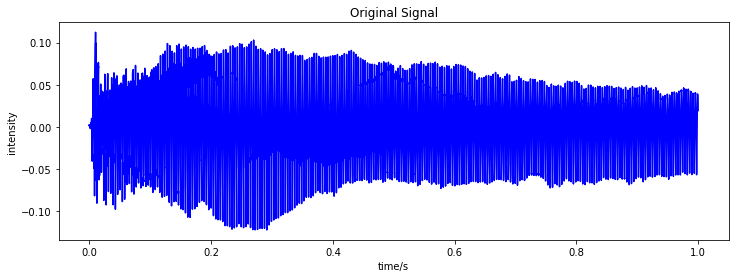

In [153]:
plt.figure(figsize=(12, 4))
plt.plot(t, sig, 'b-')
plt.xlabel('time/s')
plt.ylabel('intensity')
plt.title('Original Signal')
plt.show()

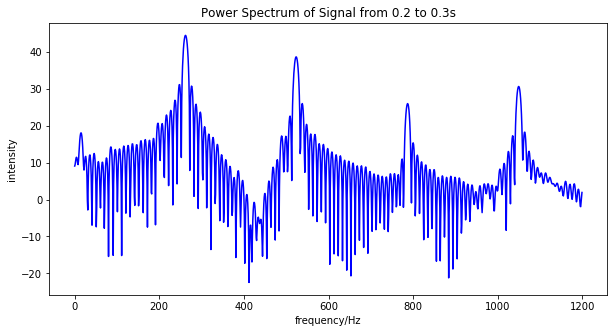

In [154]:
mask = np.zeros(N)
t1 = 0.2
t2 = 0.3
N_slice = (t2 - t1) * N
mask[int(t1 * fs):int(t2 * fs)] = 1
sig_slice = sig * mask
sig_freq = 10 * np.log10(np.abs(np.fft.fft(sig_slice)) ** 2)
plt.figure(figsize=(10, 5))
plt.plot(t[:1200] * fs, sig_freq[:1200], 'b-')
plt.xlabel('frequency/Hz')
plt.ylabel('intensity')
plt.title('Power Spectrum of Signal from 0.2 to 0.3s')
plt.show()

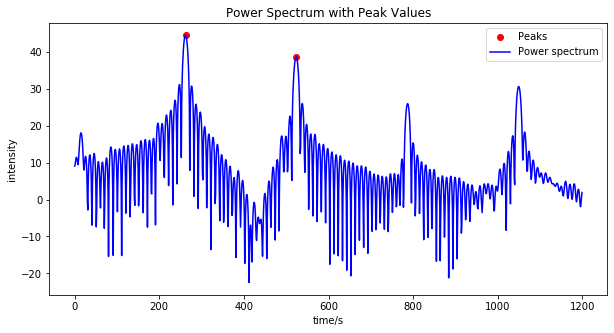

Peak frequencies are: [262, 523]


In [155]:
h = np.array([1, -1])
sig_freq_conv = np.convolve(sig_freq, h, mode='full')
peaks_freq = []
peaks_val = []
for i in range(int(N_slice)):
    if sig_freq_conv[i] * sig_freq_conv[i + 1] < 0 and sig_freq[i] > 35:
        peaks_freq.append(i)
        peaks_val.append(sig_freq[i])
plt.figure(figsize=(10, 5))
plt.plot(peaks_freq, peaks_val, 'ro', label='Peaks')
plt.plot(t[:1200] * fs, sig_freq[:1200], 'b-', label='Power spectrum')
plt.xlabel('time/s')
plt.ylabel('intensity')
plt.legend(loc='best')
plt.title('Power Spectrum with Peak Values')
plt.show()
print(f'Peak frequencies are:', peaks_freq)

In [156]:
#信号分段
#计算需要多少段
segL = 500
overlap = 0
delta = segL-overlap
segNum = np.int32(np.ceil((N-overlap)/delta));
#扩展信号
padNum = segNum*delta+overlap-N
if padNum==0:
    sigEx = sig
elif padNum>0:
    sigEx = np.hstack((sig,np.zeros(padNum)))    

#分段标签
segIdx = np.arange(0,segNum)*delta
#生成分段矩阵
segMat = as_strided(sigEx,shape=(segNum,segL),strides=(sigEx.strides[0]*delta,sigEx.strides[0]))
print(segMat.shape)

(96, 500)


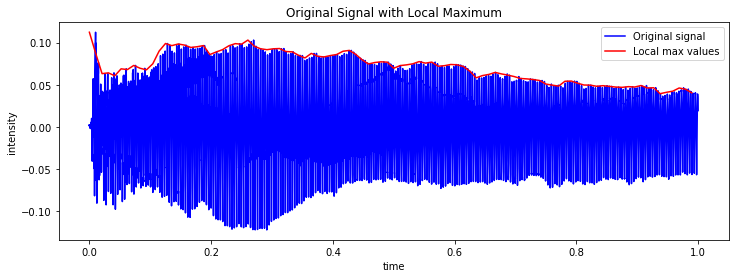

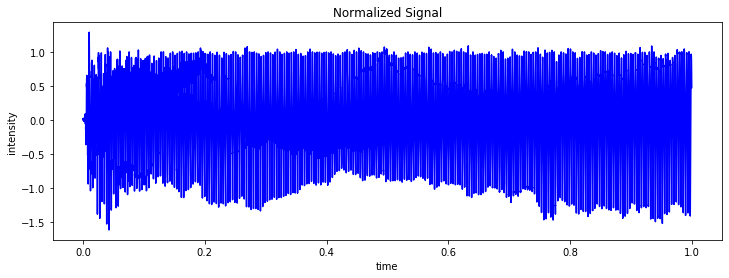

In [157]:

loc_max = np.max(segMat, axis=1)
loc_max_inerp = sinter.interp1d(t[segIdx], loc_max, kind='nearest', bounds_error=False, fill_value='extrapolate')
sig_interp = sig / loc_max_inerp(t)
plt.figure(1, figsize=(12, 4))
plt.plot(t, sig, 'b-', label='Original signal')
plt.plot(t[segIdx], loc_max, 'r-', label='Local max values')
plt.xlabel('time')
plt.ylabel('intensity')
plt.title('Original Signal with Local Maximum')
plt.legend(loc='best')

plt.figure(2, figsize=(12, 4))
plt.plot(t, sig_interp, 'b-')
plt.xlabel('time')
plt.ylabel('intensity')
plt.title('Normalized Signal')
plt.show()

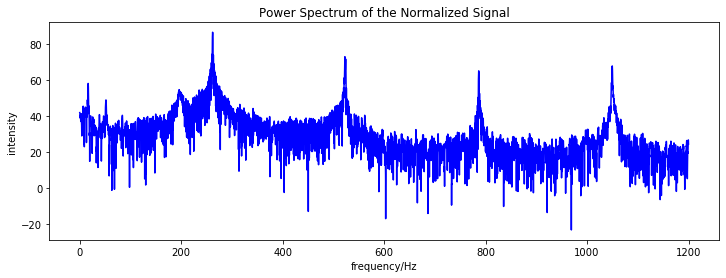

In [158]:
sig_long = np.append(sig_interp, np.zeros(9 * N))
sig_long_freq = 10 * np.log10(np.abs(np.fft.fft(sig_long))**2)
plt.figure(figsize=(12, 4))
t = np.arange(0, 10 * N) / (fs * 10)
plt.plot(fs * t[:12000], sig_long_freq[:12000], 'b-')
plt.xlabel('frequency/Hz')
plt.ylabel('intensity')
plt.title('Power Spectrum of the Normalized Signal')
plt.show()

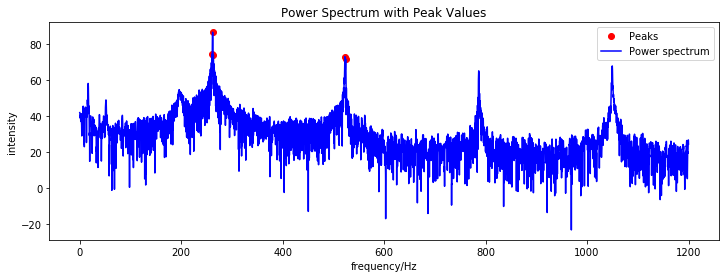

Peak frequencies are:  [260.5, 261.9, 263.3, 522.6, 524.1]


In [159]:
h = np.array([1, -1])
sig_freq_long_conv = np.convolve(sig_long_freq, h, mode='full')
peaks_freq = []
peaks_val = []
for i in range(12000):
    if sig_freq_long_conv[i] * sig_freq_long_conv[i + 1] < 0 and sig_long_freq[i] > 70:
        peaks_freq.append(i/10)
        peaks_val.append(sig_long_freq[i])
plt.figure(figsize=(12, 4))
plt.plot(peaks_freq, peaks_val, 'ro', label='Peaks')
plt.plot(t[:12000] * fs, sig_long_freq[:12000], 'b-', label='Power spectrum')
plt.title('Power Spectrum with Peak Values')
plt.xlabel('frequency/Hz')
plt.ylabel('intensity')
plt.legend(loc='best')
plt.show()
print(f'Peak frequencies are: ', peaks_freq)